In [81]:
import networkx as nx
import pprint
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.manifold import TSNE
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec as word2vec
from collections import OrderedDict

In [82]:
# 計算機の台数
N = 4
# 交流行列の成分の取る値の範囲
range_min, range_max = 1, 100 # 乱数の範囲

# 計算機の担当するニューロンを格納するdictを作成
nodes = OrderedDict()
for i in range(N):
    nodes["計算機" + str(i)] = []

# print(nodes)


# 乱数で対称な交流行列を生成
comm_matrix = [[0.0 for _ in range(N)] for _ in range(N)]
for i in range(N):
    for j in range(i, N):
        if i == j:
            comm_matrix[i][j] = 0
        else:
            comm_matrix[i][j] = int(random.uniform(range_min, range_max))
            comm_matrix[j][i] = comm_matrix[i][j]
comm_matrix = np.array(comm_matrix)
pprint.pprint(comm_matrix)

array([[ 0, 38, 74, 30],
       [38,  0, 74, 74],
       [74, 74,  0, 40],
       [30, 74, 40,  0]])


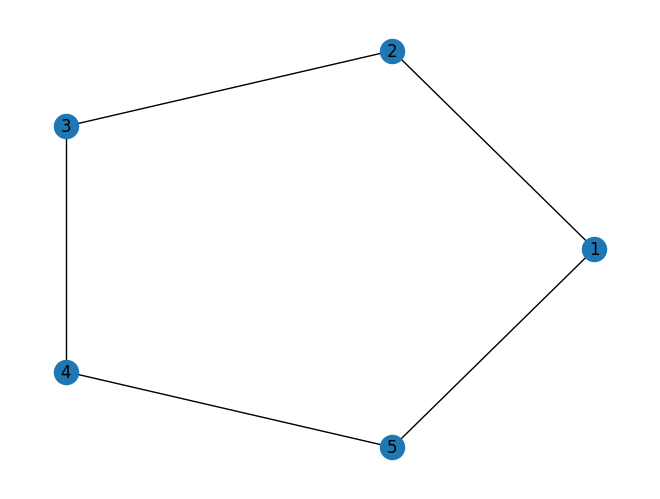

隣接リスト: {1: [2, 5], 2: [1, 3], 3: [2, 4], 4: [3, 5], 5: [1, 4]}
交流行列
[[ 0. 25. -1. -1. 36.]
 [25.  0. 80. -1. -1.]
 [-1. 80.  0. 35. -1.]
 [-1. -1. 35.  0. 62.]
 [36. -1. -1. 62.  0.]]


In [83]:
import networkx as nx
import matplotlib.pyplot as plt

# ノード数
num_nodes = 5

# 環状グラフを作成
G = nx.cycle_graph(num_nodes)

# ノードを1から始めるようにラベルを変更
mapping = {node: node + 1 for node in G.nodes()}
G = nx.relabel_nodes(G, mapping)

# グラフを描画
nx.draw_circular(G, with_labels=True)
plt.show()

# グラフから隣接リストを取得
adj_list = nx.to_dict_of_lists(G)
print(f'隣接リスト: {adj_list}')

# グラフから隣接リストを取得
adj_list = nx.to_dict_of_lists(G)

# 通信コストの行列を作成
matrix = np.zeros((num_nodes, num_nodes))
for i in range(num_nodes):
    for j in range(num_nodes):
        # 自身との通信は0
        if i == j:
            matrix[i][j] = 0
        # 隣接している場合は1~100の乱数(通信コストを与える)
        # (j+1)が隣接リストの(i+1)番目の要素(配列)に含まれているかどうかで判定
        elif j + 1 in adj_list[i + 1]:
            matrix[i][j] = random.randint(1, 100)
        # 隣接していない場合は-1(通信できないので)
        else:
            matrix[i][j] = -1

# 対称性を持たせる
for i in range(num_nodes):
    for j in range(num_nodes):
        if i < j:
            matrix[i][j] = matrix[j][i]

print("交流行列")
print(f'{matrix}')

In [84]:
print(adj_list[1])

[2, 5]


In [102]:
# 出発地ノードと目的地ノードを設定
start = 1
end = 4

# ダイクストラ法で最短経路とその重みを求める
shortest_path = nx.dijkstra_path(G, start, end)
shortest_path_weight = nx.dijkstra_path_length(G, start, end)

# 出力
print("最短経路:", shortest_path)
print("通信コスト:", shortest_path_weight)

cost = 0
for i in range(1, len(shortest_path)):
    # print(i)
    print(shortest_path[i-1]-1, shortest_path[i]-1)
    cost += matrix[shortest_path[i-1]-1][shortest_path[i]-1]
    
print(cost)

最短経路: [1, 5, 4]
通信コスト: 2
0 4
4 3
98.0


In [86]:
import random
import pprint
import copy
import re

# 計算機ととニューロンを定義
pcs = ["pc1", "pc2", "pc3", "pc4"]
neurons = ["n1", "n2", "n3", "n4", "n5", "n6", "n7", "n8", "n9", "n10", "n11", "n12"]

def assign_tasks_to_pc(pcs: list, neurons: list, num_task: int) -> dict:
    """PCにランダムに任意の個数のタスク

    Args:
        pcs (list): 計算機のリスト
        neurons (list): ニューロンのリスト
        num_task (int): 一つの計算機が担当するタスクの数

    Returns:
        dict: PCの担当しているタスクを表したdict
    """    
    assignments = {}
    neurons_copy = copy.deepcopy(neurons)
    for pc in pcs:
        # ランダムに3つのニューロンを選択
        neurons = random.sample(neurons_copy, num_task)
        
        # ランダムに取得したニューロンをPCに割り当てる
        assignments[pc] = neurons
        
        # 割り当てたニューロンを再度割り当てないように削除
        neurons_copy = [neuron for neuron in neurons_copy if neuron not in neurons]
    return assignments


def sort_assignments(assignments: dict) -> dict:
    """PCの担当しているタスクを表したdictをソートする関数

    Args:
        assignments (dict): PCの担当しているタスクを表したdictをソートする関数

    Returns:
        dict: 担当するニューロンをソートしたdict
    """    
    # 文字列を添字(数値)に変換する関数
    def atoi(text):
        return int(text) if text.isdigit() else text

    def natural_keys(text):
        return [ atoi(c) for c in re.split(r'(\d+)', text) ]

    sorted_assignments = {}
    for pc, tasks in assignments.items():
        sorted_assignments[pc] = sorted(sorted(tasks, key=natural_keys), key=natural_keys)
    return sorted_assignments


def swap_tasks_between_pc(assignments: dict, pc1: str, pc2: str) -> dict:
    """PCの担当するタスクを1つ交換する関数

    Args:
        assignments (dict): PCの担当しているタスクを表したdict
        pc1 (str): 交換元(探索中)のPC
        pc2 (str): 交換先のPC

    Returns:
        dict: ニューロンを入れ替えた後のdict
    """
    # PCをランダムに2つ選ぶ
    # pc1 = random.choice(list(assignments.keys()))
    # pc2 = random.choice(list(assignments.keys()))
    # pc1とpc2が同じ場合は、pc2を再度ランダムに選ぶ
    # while pc1 == pc2:
    #     pc2 = random.choice(list(assignments.keys()))

    # PC1のタスクとPC2のタスクをランダムに1つ選ぶ
    task1 = random.choice(assignments[pc1])
    task2 = random.choice(assignments[pc2])

    # PC1とPC2のタスクを交換する
    new_assignments = copy.deepcopy(assignments)
    new_assignments[pc1].remove(task1)
    new_assignments[pc1].append(task2)
    new_assignments[pc2].remove(task2)
    new_assignments[pc2].append(task1)

    return new_assignments


assignments = assign_tasks_to_pc(pcs, neurons, 3)
assignments = sort_assignments(assignments)
pprint.pprint(assignments)
print()
print("swap後")
new_assignments = swap_tasks_between_pc(assignments, "pc1", "pc2")
new_assignments = sort_assignments(new_assignments)
pprint.pprint(new_assignments)

{'pc1': ['n2', 'n7', 'n9'],
 'pc2': ['n4', 'n5', 'n6'],
 'pc3': ['n1', 'n3', 'n10'],
 'pc4': ['n8', 'n11', 'n12']}

swap後
{'pc1': ['n2', 'n6', 'n9'],
 'pc2': ['n4', 'n5', 'n7'],
 'pc3': ['n1', 'n3', 'n10'],
 'pc4': ['n8', 'n11', 'n12']}


In [87]:
import random
import pprint
import copy
import re

# 計算機ととニューロンを定義
pcs = [1, 2, 3, 4]
neurons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

def assign_tasks_to_pc(pcs: list, neurons: list, num_task: int) -> dict:
    """PCにランダムに任意の個数のタスク

    Args:
        pcs (list): 計算機のリスト
        neurons (list): ニューロンのリスト
        num_task (int): 一つの計算機が担当するタスクの数

    Returns:
        dict: PCの担当しているタスクを表したdict
    """    
    assignments = {}
    neurons_copy = copy.deepcopy(neurons)
    for pc in pcs:
        # ランダムに3つのニューロンを選択
        neurons = random.sample(neurons_copy, num_task)
        
        # ランダムに取得したニューロンをPCに割り当てる
        assignments[pc] = neurons
        
        # 割り当てたニューロンを再度割り当てないように削除
        neurons_copy = [neuron for neuron in neurons_copy if neuron not in neurons]
    return assignments


def sort_assignments(assignments: dict) -> dict:
    """PCの担当しているタスクを表したdictをソートする関数

    Args:
        assignments (dict): PCの担当しているタスクを表したdictをソートする関数

    Returns:
        dict: 担当するニューロンをソートしたdict
    """    
    # 文字列を添字(数値)に変換する関数
    # def atoi(text):
    #     return int(text) if text.isdigit() else text

    # def natural_keys(text):
    #     return [ atoi(c) for c in re.split(r'(\d+)', text) ]

    sorted_assignments = {}
    for pc, tasks in assignments.items():
        sorted_assignments[pc] = sorted(tasks)
    return sorted_assignments


def swap_tasks_between_pc(assignments: dict, pc1: int, pc2: int) -> dict:
    """PCの担当するタスクを1つ交換する関数

    Args:
        assignments (dict): PCの担当しているタスクを表したdict
        pc1 (str): 交換元(探索中)のPC
        pc2 (str): 交換先のPC

    Returns:
        dict: ニューロンを入れ替えた後のdict
    """
    # PCをランダムに2つ選ぶ
    # pc1 = random.choice(list(assignments.keys()))
    # pc2 = random.choice(list(assignments.keys()))
    # pc1とpc2が同じ場合は、pc2を再度ランダムに選ぶ
    # while pc1 == pc2:
    #     pc2 = random.choice(list(assignments.keys()))

    # PC1のタスクとPC2のタスクをランダムに1つ選ぶ
    task1 = random.choice(assignments[pc1])
    task2 = random.choice(assignments[pc2])

    # PC1とPC2のタスクを交換する
    new_assignments = copy.deepcopy(assignments)
    new_assignments[pc1].remove(task1)
    new_assignments[pc1].append(task2)
    new_assignments[pc2].remove(task2)
    new_assignments[pc2].append(task1)

    return new_assignments


assignments = assign_tasks_to_pc(pcs, neurons, 3)
assignments = sort_assignments(assignments)

print("swap前")
pprint.pprint(assignments)
print("swap後")
new_assignments = swap_tasks_between_pc(assignments, 1, 4)
new_assignments = sort_assignments(new_assignments)
pprint.pprint(new_assignments)

swap前
{1: [4, 8, 9], 2: [1, 5, 6], 3: [3, 7, 10], 4: [2, 11, 12]}
swap後
{1: [8, 9, 11], 2: [1, 5, 6], 3: [3, 7, 10], 4: [2, 4, 12]}
